# Table of contents
* Part 1. [Getting the data](#Part1)
* Part 2. [Analyzing the data](#Part2)
    1. [Distribution of responses](#1)\
        1.1. [Informal comparison to Gaussian](#1.1)
    2. [Investigating bimodality](#2)\
        2.1 [Mode clusters...](#2.1)
        * effect on skew
    3. [Investigating variance of responses](#3)\
        3.1 [As a function of price volatility](#3.1)\
        3.2 [As a function of response time](#3.2)
    4. [Outlier analysis](#4)
        * center around median
    
 
* Part 3. [Conclusion](#Part3)

# Part 1: Getting the data <a class="anchor" id="Part1"></a>

In [3]:
import numpy as np
import pandas as pd
import quantumrandom
import random
from tqdm.notebook import tqdm
# disable locks due to random deadlocks
tqdm.get_lock().locks = []
from web3 import Web3

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
COLORS_10 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3',
             '#fdb462', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd']
PALLETTE_10 = sns.set_palette(sns.color_palette(COLORS_10))
CHAINLINK_BLUE = '#2b5cdc'
CHAINLINK_BLUE_LIGHT = '#698CE5'
GREEN = '#69e584'

from configs import (
    INFURA_URL,
    INFURA_PROVIDER,
    ETH_USD_PRICE_CONTRACT_ADDR,
    CHAINLINK_ABI
)

from utils import (
    connect,
    load_all_price_response_data,
    approx_earliest_eth_block,
    get_all_entries,
    get_prices
)

convert_unixtime = lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
filename = lambda rnd, other_info: 'eth_usd_price_round_' + '{}_{}.csv'.format(rnd, other_info)
FILE_PREFIX = 'eth_usd_price_round'

Connect. Might have to run this a few times.

In [4]:
WEB3, CONTRACT = connect()

* We populate `df_answers` with all past oracle responses for this price contract.
* We do this by querying `ResponseReceived` events.
* We write a general function for querying *event* data from the blockchain.
    * This is because `web3.utils.filters.Filter.get_all_entries()` runs into disconnection issues when too much data is queried at once.

In [5]:
df_answers = load_all_price_response_data()

Latest round: 480
First block: 2020-04-23 20:16:02.
Round 478 USD-ETH price response: 2020-04-24 05:24:08.
Querying blockchain in chunks of 500 blocks. 6 chunks total.


  0%|          | 0/525 [00:00<?, ?it/s]

Done.
Augmenting dataframe...
Adding timestamps...


100%|██████████| 525/525 [01:09<00:00,  7.57it/s]

Done.


# Part 2: Analyzing the data <a class="anchor" id="Part2"></a>

In [6]:
df_answers

,price,answer_id,oracle,blockNumber,timestamp,date,price_float
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,9288039,1579122628,2020-01-15 21:10:28,166.313515
1,16592100000,1,0x58c69aFF4Df980357034eA98AaD35bbF78cBD849,9288039,1579122628,2020-01-15 21:10:28,165.921000
2,16582658130,1,0x24A718307Ce9B2420962fd5043fb876e17430934,9288039,1579122628,2020-01-15 21:10:28,165.826581
3,16627988740,1,0x7e94A8A23687D8C7058Ba5625dB2Ce358bCbd244,9288039,1579122628,2020-01-15 21:10:28,166.279887
4,16582658130,1,0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A,9288039,1579122628,2020-01-15 21:10:28,165.826581
...,...,...,...,...,...,...,...
10060,18790000000,480,0x240BaE5A27233Fd3aC5440B5a598467725F7D1cd,9933584,1587709279,2020-04-24 06:21:19,187.900000
10061,18715888729,480,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,9933584,1587709279,2020-04-24 06:21:19,187.158887
10062,18794924442,480,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,9933584,1587709279,2020-04-24 06:21:19,187.949244
10063,18774625000,480,0xF5a3d443FccD7eE567000E43B23b0e98d96445CE,9933584,1587709279,2020-04-24 06:21:19,187.746250


## 1. Distribution of price responses per heartbeat, for a recent 24 hour period <a class="anchor" id="1"></a>

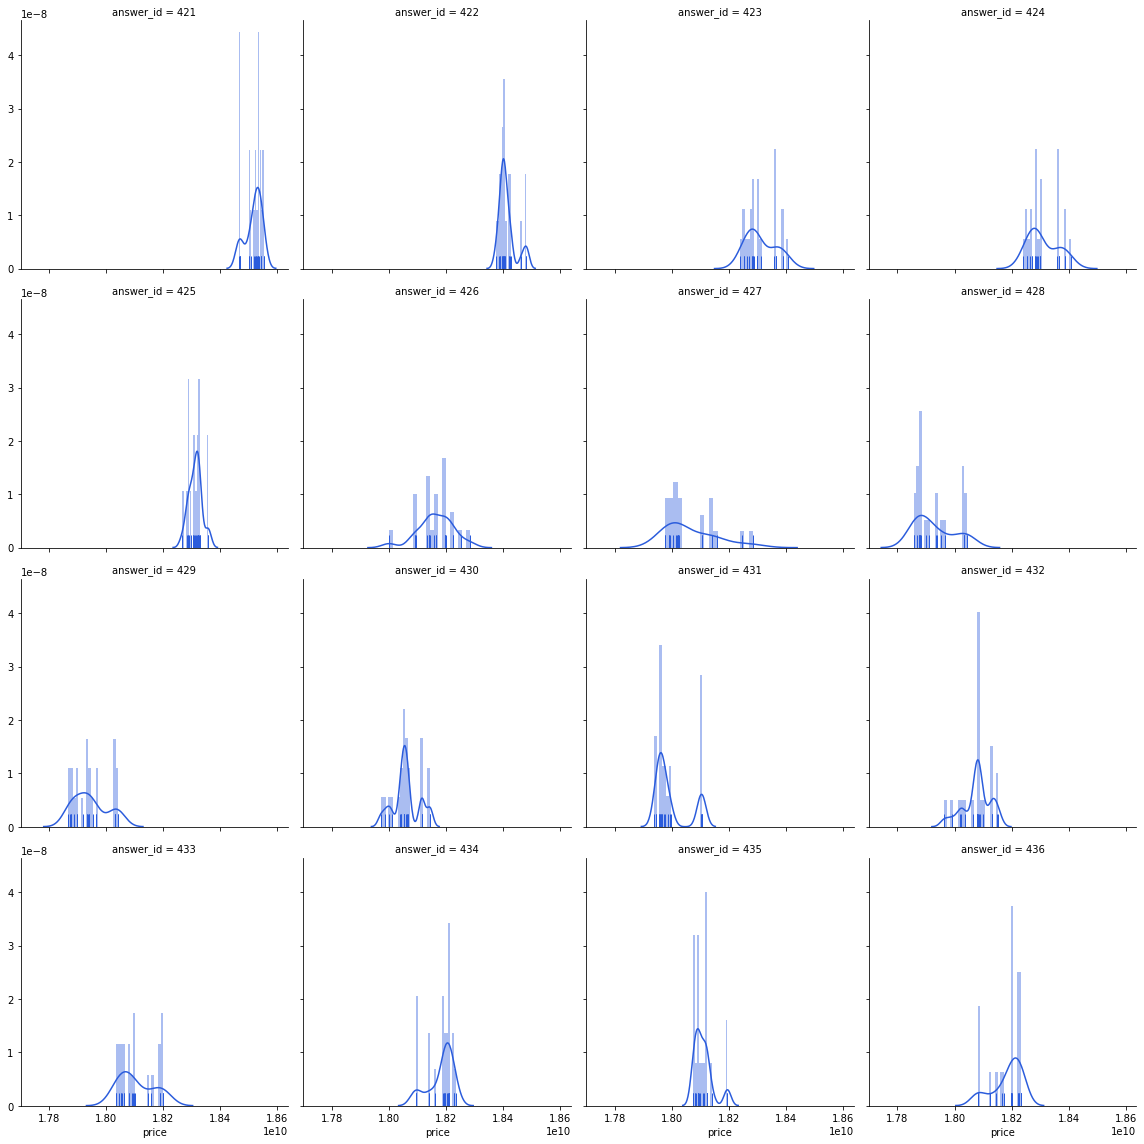

In [7]:
HOURS = 24

#now = time.time()
now = 1587693973

ts = now - timedelta(hours=HOURS).total_seconds()
# get first 16
firstn = 16
first_ans_id = min(df_answers[df_answers['timestamp']>=ts]['answer_id'])
recent_answers = df_answers[(df_answers['timestamp']>=ts) & (df_answers['answer_id']<first_ans_id+firstn)]

g = sns.FacetGrid(recent_answers, col="answer_id", col_wrap=4, height=4, aspect=1)
g.map(sns.distplot, "price", rug=True, **{'bins': 20, 'color': CHAINLINK_BLUE});
#plot.savefig("eth_usd_dists.png")

### Observations:
- We can't assume, based on these distributions, that we are always dealing with normally distributed data.
    - This is perhaps due to the fact that we have only ~20 responses. Fitting distributions to small data sets is always a problem. But perhaps there's something else going on here ...
- Often we'll see what appears to be a **multi/bi-modal distribution**.
    - Could this be a result of prices being reported from different exchanges? i.e. some nodes aren't aggregating reponses, instead they report from one or two sources? I could test this hypothesis if I knew where the oracles were getting their data from.
    - Idea: Oracles that aggregate their responses from multiple exchanges are likely to have responses closer to the mean/median. Penalizing oracles with responses further from the center of the distribution would incentivize oracles to gather information from many sources, which is what we want.
        - Caveat: a weighted average of prices from exchanges, where the weight is a function(\*) of *trading volume* is a better aggregation method for price oracles than simple average. This is because prices reported from various exchanges, weighted by the trading volume of those exchanges, is clearly closer to what we envision as the "true price". How do we enforce/incentivise this? Idea: somehow incentivise both accurate (close to mean/median) responses as well as responses representing a large trading volume?
        - (\*) I say *function of* trading volume, because the weighting should be proportional to trading volume, but not exactly equal to it due to interactions such as liquidity (e.g. trading volume is directly correlated with liquidity which has an effect on price.

## 1.1 Informal comparison to Gaussian
One might assume that the irregularities with the above distributions is simply an artifact arising from a small sample ($n=21$, see histogram directly below). We can informally test this by plotting samples ($n=21$) from a *true* normal distribution and then visually compare to our plots above.

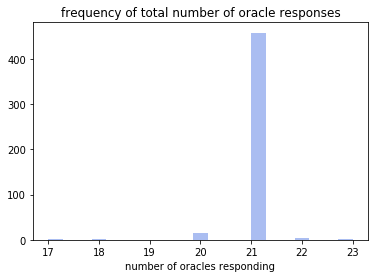

In [8]:
x = df_answers[['answer_id']].groupby(['answer_id']).agg(
        count_col=pd.NamedAgg(column="answer_id", aggfunc="count")
    ).rename(columns={'count_col': 'n_oracles'})

sns.distplot(x, kde=False, axlabel="number of oracles responding", color=CHAINLINK_BLUE).set_title(
    'frequency of total number of oracle responses');

In [9]:
def generate_random_gaussians(sample_size, ndists):
    print('Drawing {} random samples (n={}) from Gaussian'.format(ndists, sample_size))
    d = defaultdict(list)
    for i in range(ndists):
        # we even seed with a quantum random number generator!
        seed = quantumrandom.get_data()
        np.random.seed(seed)
        x = np.random.normal(size=sample_size)
        for j in range(21):
            d['i'].append(i)
            d['x'].append(x[j])
    return pd.DataFrame(d)

Drawing 16 random samples (n=21) from Gaussian


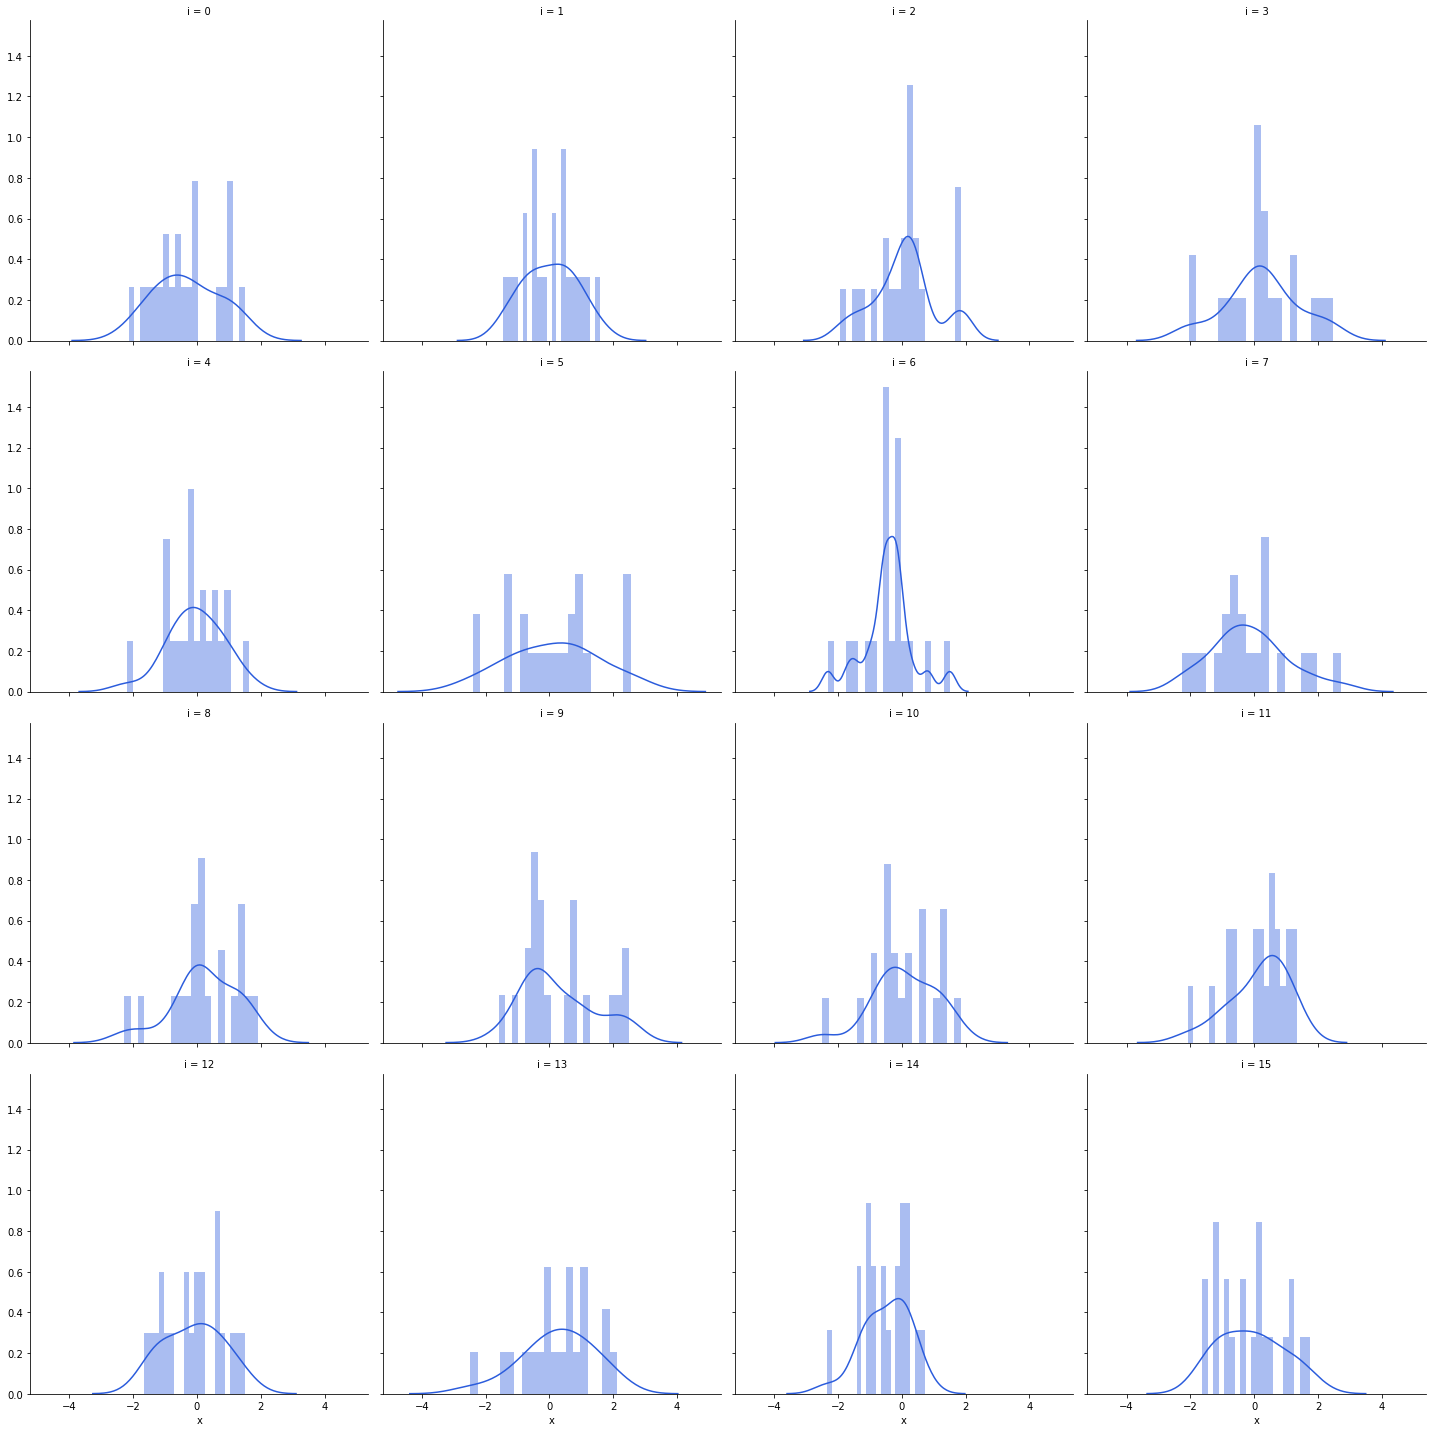

In [10]:
N_SAMPLES = 16

df = generate_random_gaussians(21, N_SAMPLES)
g = sns.FacetGrid(df, col="i", col_wrap=4, height=5, aspect=1)
g.map(sns.distplot, "x", **{'bins': 20, 'color': CHAINLINK_BLUE});

### Observations:
- We note, visually, that bimodal distributions are not that common in samples ($n = 21$) generated from true normal distributions, suggesting that there is some underlying factor for why our oracle response distributions are multimodal. Although, we would have to test this more formally before a conclusion.

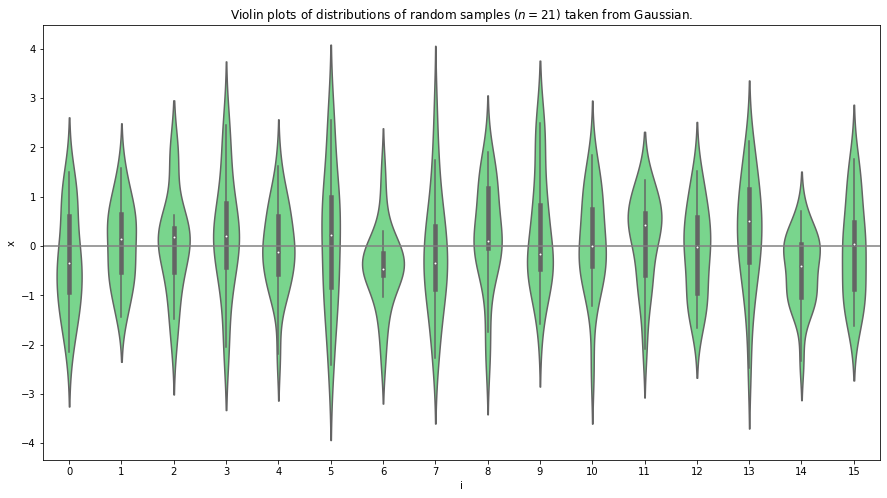

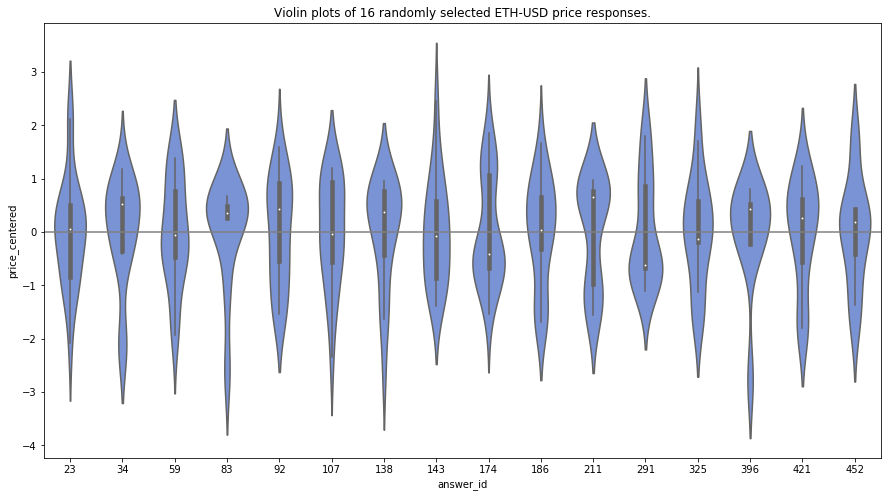

In [11]:
### violin plots for further visual study ###

f, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(ax=ax, x="i", y="x", 
            height=1, aspect=1,
            #hue="oracle",
            color=GREEN,
            data=df).set_title(
    'Violin plots of distributions of random samples ($n=21$) taken from Gaussian.')
ax = g.axes
ax.axhline(0, color='grey');

# center data -> mean=0, std=1
df_answers.loc[:,'price_centered'] = df_answers.groupby('answer_id')['price_float'].transform(
    lambda x: (x - x.mean()) / x.std()
) 

sample_ans_ids = df_answers['answer_id'].sample(N_SAMPLES)
df_sample = df_answers[df_answers['answer_id'].isin(sample_ans_ids)]

f, ax = plt.subplots(1, 1, figsize=(15,8))
g = sns.violinplot(ax=ax, x="answer_id", y="price_centered",
            height=1, aspect=1,
            #hue="oracle",
            color=CHAINLINK_BLUE_LIGHT,
            data=df_sample).set_title(
    'Violin plots of {} randomly selected ETH-USD price responses.'.format(N_SAMPLES))
ax = g.axes
ax.axhline(0, color='grey');

### Observations:
* Note that the above distributions of price responses are centered (i.e. mean 0, std 1), so they hide any differences in variance between rounds.
* They look pretty okay, but let's focus on how they're different from samples drawn from normals.
     * They tend to be more skewed. They have a sperm-like appearance. Yes, that's a technical term. They typically have these long tails on one end.
     * Idea: arrows showing price movements???
         * Suggest weighing by recency!
         * Also: all depends on context! High-frequency vs contract that depends on average price during day.

## 2. Exploring variance of responses across time
We are interested in how variance varies across different time periods. We again compare to same-size samples drawn from a Gaussian.

Drawing 16 random samples (n=21) from Gaussian


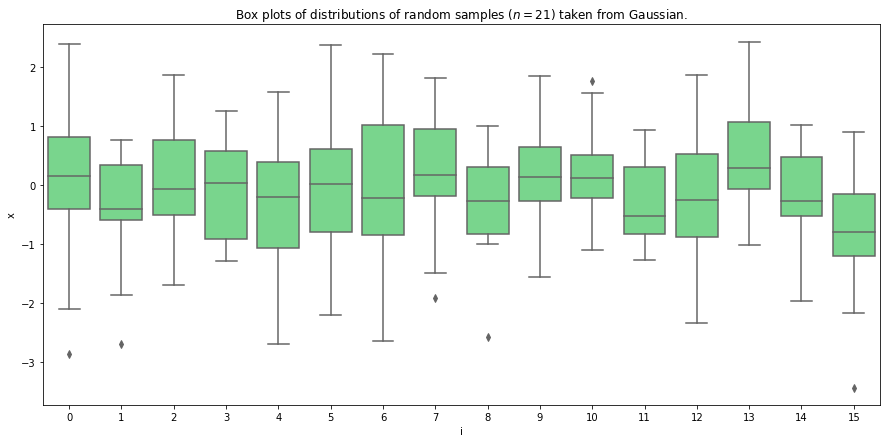

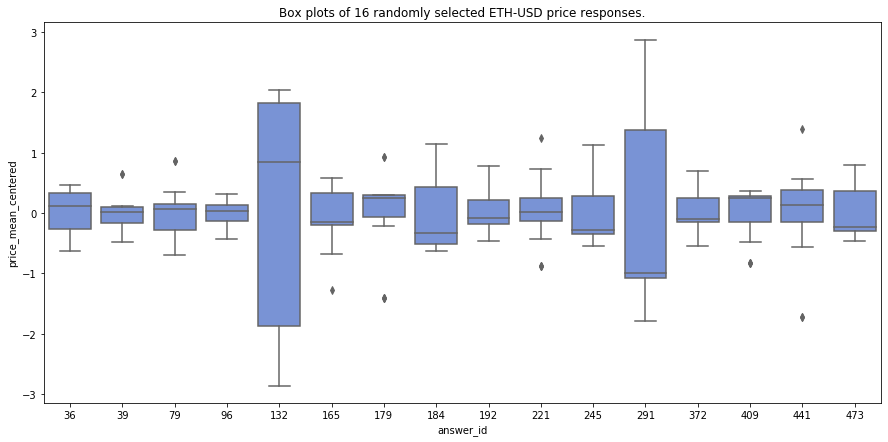

In [12]:
df_norm = generate_random_gaussians(21, N_SAMPLES)

f, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(ax=ax, x="i", y="x",
            #height=1, aspect=1,
            #hue="oracle",
            color=GREEN,
            data=df_norm).set_title(
    'Box plots of distributions of random samples ($n=21$) taken from Gaussian.'.format(N_SAMPLES))

# mean center -> mean=0, keep variace the same
df_answers.loc[:,'price_mean_centered'] = df_answers.groupby('answer_id')['price_float'].transform(lambda x: x - x.mean()) 

sample_ans_ids = df_answers['answer_id'].sample(N_SAMPLES)
df_sample = df_answers[df_answers['answer_id'].isin(sample_ans_ids)]

f, ax = plt.subplots(1, 1, figsize=(15,7))
g = sns.boxplot(ax=ax, x="answer_id", y="price_mean_centered",
            #height=1, aspect=1,
            #hue="oracle",
            color=CHAINLINK_BLUE_LIGHT,
            data=df_sample).set_title(
    'Box plots of {} randomly selected ETH-USD price responses.'.format(N_SAMPLES))

### Observations:
* Informal, visual inspection:
    * We have what appears might be a significant difference between variances in our oracle responses.
    * We again see some examples of a skew - the "line" in the box plot is often far from the center of the rectangle.

## 2.2.1 Exploring potential causes of variance in responses

**WORK IN PROGRESS**

### Gathering data
TODO
* do multivariate analysis with the following variables:
    * length of round
    * standard deviation of reporting times
    * price volatility (between start and end of round)
* how much does this explain the variability in the responses?

In [ ]:
CRYPTO_COMPARE_API_URL = 'https://min-api.cryptocompare.com/data/v2/histominute?fsym={from}&tsym={to}&toTs={ts}'

In [53]:
# get start and end times of rounds
first_block = approx_earliest_eth_block(1)['number']
start = get_all_entries(
    CONTRACT.events.NewRound(),
    first_block,
    query=(('args', 'roundId'), ('blockNumber',)),
    chunk_size=3000
)

print('Converting block numbers to timestamps...')
start['ts_start'] = []
for i,_ in enumerate(tqdm(start['roundId'])):
    start['ts_start'].append(WEB3.eth.getBlock(start['blockNumber'][i])['timestamp'])
    
end = {'roundId':[], 'ts_end': []}
for i in tqdm(start['roundId']):
    end['roundId'].append(i)
    end['ts_end'].append(CONTRACT.functions.getTimestamp(i).call())
    
# change column names
df_start = pd.DataFrame(start).set_index('roundId')
df_end = pd.DataFrame(end).set_index('roundId')
df_ts = df_start.join(df_end)
df_ts.to_csv(filename(str(LATEST_ROUND), 'round_start_end_ts'))

First block: 2020-01-15 18:41:52.
Round 1 USD-ETH price response: 2020-01-15 21:10:28.
Querying blockchain in chunks of 3000 blocks. 215 chunks total.



Done.
Converting block numbers to timestamps...


In [265]:
# VAR OF INTEREST: response variance
std_price = df_answers.groupby('answer_id').apply(np.std)['price']
# time between start and end
range_ = pd.DataFrame(df_ts['ts_end'] - df_ts['ts_start'])
# standard deviation of response times
std = df_answers.groupby('answer_id').apply(np.std)['timestamp']
# volatility of price during round
vol = df_ts[['ts_start', 'ts_end']].apply(volatility, axis=1)


# TODO remove first 3 rows
#df_ = df_.iloc[3:]

In [312]:
# VAR OF INTEREST: response variance
std_price = df_answers.groupby('answer_id').apply(np.std)['price']

In [313]:
df_ = pd.concat([std_price, std, range_, vol], axis=1, join="inner").dropna()
df_.columns = ['response_variance', 'ts_range', 'ts_std', 'price_volatility']
df_

,response_variance,ts_range,ts_std,price_volatility
176,2.953300e+07,15.229166,3035,0.341696
177,3.993768e+07,22.610617,1874,0.376701
178,3.772246e+07,28.713934,3700,0.391004
180,1.696424e+07,25.392125,4627,0.202562
181,4.803297e+07,15.472152,1926,0.302193
...,...,...,...,...
454,6.070892e+07,19.891543,3694,0.218264
455,6.757848e+07,13.368830,3642,0.132364
456,6.575673e+07,33.392329,3723,0.199151
457,9.224517e+07,12.097300,3336,0.442123


In [314]:
pd.options.display.max_columns = None
# removing some outliers
df_ = df_[df_.ts_range < 100]

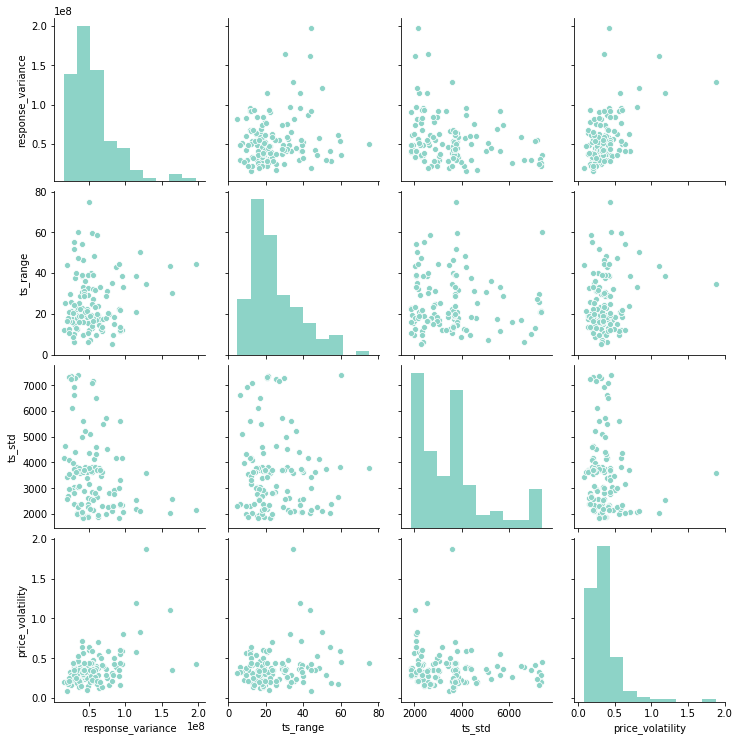

In [315]:
g = sns.pairplot(df_)

In [273]:
volatility([1587654044, 1587655481])

nan

In [165]:
### getting price volatility ###
CRYPTO_COMPARE_API_URL = 'https://min-api.cryptocompare.com/data/v2/histominute?fsym=ETH&tsym=USD&toTs={ts}&limit={limit}'
KEY = 'a629da4917f3816b8575a64610ed94a857598d2835a75136d8c79ba35b753861'
headers = {'Apikey': KEY}

In [258]:
# PRICE VOLATILITY
### NOTE: ONLY AVAILABLE FOR LAST 7 DAYS ###
def get_prices(from_, to_, limit=30):
    res = {
        'time': [],
        'high': [],
        'low': [],
        'open': [],
        'close': []
    }
    # ignore volume data for now
    r = requests.get(CRYPTO_COMPARE_API_URL.format(ts=to_, limit=limit), headers=headers)
    d = json.loads(r.content.decode('utf-8'))
    for x in d['Data']['Data']:
        if x['time'] < from_:
            break
        for k in res.keys():
            res[k].append(x[k])
    else:
        # need to keep querying to get all data in range
        df = get_prices(from_, min(res['time']) - 1)
        return pd.concat([pd.DataFrame(res), df])
        
    return pd.DataFrame(res)

In [259]:
# we will use variance of price over period of time. price in minute will be mean of high, low, open, close
def volatility(ts):
    ### NOTE: ONLY AVAILABLE FOR LAST 7 DAYS ###
    if ts[0] > time.time() - 7 * 86400:
        df = get_prices(ts[0], ts[1])
        df['price'] = df[['high', 'low', 'open', 'close']].mean(axis=1)
        return df.price.std()
    else:
        return np.nan

In [264]:
vol = df_ts[['ts_start', 'ts_end']].apply(volatility, axis=1)

KeyboardInterrupt: 

In [201]:
df_ts#[400:][['ts_start', 'ts_end']]

,blockNumber,ts_start,ts_end
roundId,,,
2,9288036,1579122568,1586382065
3,9834003,1586381994,1586434893
8,9838959,1586448013,1586455311
7,9838903,1586447154,1586448061
6,9838425,1586440886,1586447252
...,...,...,...
451,9929879,1587660112,1587661345
450,9929687,1587657631,1587660214
449,9929611,1587656684,1587657899


In [249]:
volatility(df_ts.loc[2])

blockNumber       9288036
ts_start       1579122568
ts_end         1586382065
Name: 2, dtype: int64
2020-04-17 04:39:33


nan

In [247]:
df_ts

,blockNumber,ts_start,ts_end
roundId,,,
2,9288036,1579122568,1586382065
3,9834003,1586381994,1586434893
8,9838959,1586448013,1586455311
7,9838903,1586447154,1586448061
6,9838425,1586440886,1586447252
...,...,...,...
451,9929879,1587660112,1587661345
450,9929687,1587657631,1587660214
449,9929611,1587656684,1587657899


In [217]:
pd.concat([std, pd.DataFrame(ts_range), pd.DataFrame(volatility)], axis=1)[300:350]

,timestamp,0,0
301,18.823684,1668.0,NaN
302,24.275441,1047.0,NaN
303,14.386785,111.0,NaN
304,21.940344,678.0,NaN
305,18.113149,688.0,NaN
306,11.801072,1006.0,NaN
307,18.012971,1466.0,NaN
308,30.607307,721.0,NaN
309,45.592298,1493.0,NaN
310,31.447036,1406.0,NaN


In [197]:
list(volatility)

[nan,
 nan,
 0.43752701812773864,
 0.3516386754390312,
 nan,
 nan,
 nan,
 0.5998629995920466,
 0.2063809375835104,
 nan,
 0.28541675625094376,
 nan,
 0.17668223709028097,
 nan,
 0.4426275558816957,
 0.1495517945305619,
 nan,
 nan,
 0.21871932964713084,
 0.3460196942862484,
 0.43751468485339673,
 nan,
 0.42211907813913596,
 nan,
 nan,
 nan,
 0.8318029792183705,
 nan,
 nan,
 0.35627083979793317,
 nan,
 nan,
 0.3475734624909632,
 0.25136779055605296,
 0.44011192637101054,
 0.3490745830279342,
 nan,
 0.1756271787451393,
 nan,
 nan,
 0.4971071286069257,
 nan,
 0.6993982987077689,
 0.2092933258289858,
 nan,
 nan,
 nan,
 0.3023001205809017,
 nan,
 0.42663346750037723,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.16806384795442356,
 nan,
 nan,
 0.44212311572950774,
 0.19915059580534497,
 0.13236445694507706,
 0.21826438417169988,
 0.33625039473135243,
 nan,
 nan,
 0.3541825549883321,
 nan,
 nan,
 nan]

In [153]:
list(volatility)

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [61]:
# amend dataframe

# variance as function of length of time (end - start)
df_std = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="price", aggfunc="std")
    ).\
    rename(columns={'count_col': 'price_std'})

df_std_ts = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="timestamp", aggfunc="std")
    ).\
    rename(columns={'count_col': 'ts_std'})

df_ = df_std.join(df_ts).join(df_std_ts)
df_['time_delta'] = df_.ts_end - df_.ts_start
# remove first 3 rows
df_ = df_.iloc[3:]
df_


,price_std,blockNumber,ts_start,ts_end,ts_std,time_delta
answer_id,,,,,,
4,2.159717e+07,9837987.0,1.586435e+09,1.586439e+09,33.924145,3982.0
5,1.793557e+07,9838260.0,1.586439e+09,1.586441e+09,24.395648,2383.0
6,2.688466e+07,9838425.0,1.586441e+09,1.586447e+09,17.028268,6366.0
7,3.144767e+07,9838903.0,1.586447e+09,1.586448e+09,5.353681,907.0
8,1.981088e+07,9838959.0,1.586448e+09,1.586455e+09,21.059214,7298.0
...,...,...,...,...,...,...
460,9.511251e+07,9931359.0,1.587680e+09,1.587683e+09,14.071755,2395.0
461,8.341454e+07,9931547.0,1.587683e+09,1.587683e+09,17.704048,629.0
463,6.963466e+07,9931710.0,1.587685e+09,1.587686e+09,53.609034,1383.0


In [140]:
# variance as function of length of time (end - start)
df_std = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="price", aggfunc="std")
    ).\
    rename(columns={'count_col': 'price_std'})

df_std_ts = df_answers.groupby(['answer_id']).\
    agg(
        count_col=pd.NamedAgg(column="timestamp", aggfunc="std")
    ).\
    rename(columns={'count_col': 'ts_std'})

df_ = df_std.join(df_ts).join(df_std_ts)
df_['time_delta'] = df_.ts_end - df_.ts_start
# remove first 3 rows
df_ = df_.iloc[3:]
df_

,price_std,blockNumber,ts_start,ts_end,ts_std,time_delta
answer_id,,,,,,
4,2.159717e+07,9837987.0,1.586435e+09,1.586439e+09,0.0,3982.0
5,1.793557e+07,9838260.0,1.586439e+09,1.586441e+09,0.0,2383.0
6,2.688466e+07,9838425.0,1.586441e+09,1.586447e+09,0.0,6366.0
7,3.144767e+07,9838903.0,1.586447e+09,1.586448e+09,0.0,907.0
8,1.981088e+07,9838959.0,1.586448e+09,1.586455e+09,0.0,7298.0
...,...,...,...,...,...,...
410,3.987064e+07,9924384.0,1.587587e+09,1.587589e+09,0.0,2399.0
411,2.904027e+07,9924559.0,1.587589e+09,1.587593e+09,0.0,3434.0
415,3.049482e+07,9925104.0,1.587596e+09,1.587600e+09,0.0,3737.0


In [132]:
df_answers

,price,answer_id,oracle,timestamp,date,price_float,price_centered,price_mean_centered
0,16631351520,1,0x0Ce0224ba488ffC0F46bE32b333a874Eb775c613,1.579123e+09,2020-01-15 21:10:28,166.313515,0.428442,0.149352
1,16670000000,1,0x83dA1beEb89Ffaf56d0B7C50aFB0A66Fb4DF8cB1,1.579123e+09,2020-01-15 21:10:28,166.700000,1.537143,0.535837
2,16614295610,1,0x049Bd8C3adC3fE7d3Fc2a44541d955A537c2A484,1.579123e+09,2020-01-15 21:10:28,166.142956,-0.060837,-0.021207
3,16563811450,1,0x79C6e11bE1C1ed4D91FbE05D458195A2677F14A5,1.579123e+09,2020-01-15 21:10:28,165.638115,-1.509065,-0.526049
4,16643715000,1,0x4565300C576431e5228e8aA32642D5739CF9247d,1.579123e+09,2020-01-15 21:10:28,166.437150,0.783111,0.272987
...,...,...,...,...,...,...,...,...
373,18316583767,415,0x4565300C576431e5228e8aA32642D5739CF9247d,1.587600e+09,2020-04-23 00:02:25,183.165838,1.001188,0.305310
374,18293379251,415,0x85aEace84a130bC1AcCcE2a9F4F933F6765b0B9B,1.587600e+09,2020-04-23 00:02:25,182.933793,0.240255,0.073265
375,18293379251,415,0x8cfb1D4269f0daa003CDEa567aC8f76c0647764a,1.587600e+09,2020-04-23 00:02:25,182.933793,0.240255,0.073265
376,18279000000,415,0xF5a3d443FccD7eE567000E43B23b0e98d96445CE,1.587600e+09,2020-04-23 00:02:25,182.790000,-0.231276,-0.070527


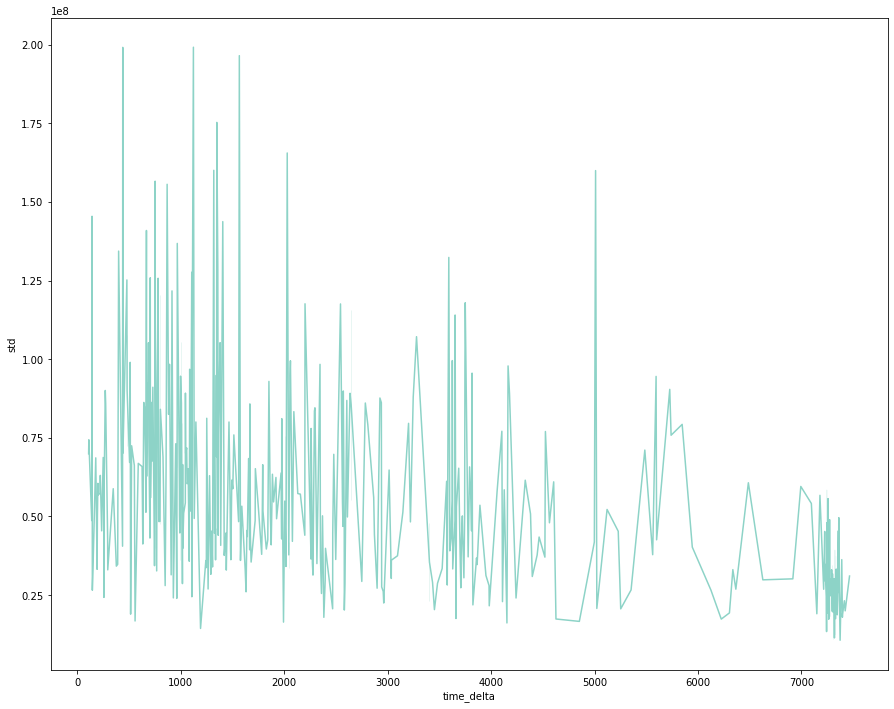

In [131]:
f, ax = plt.subplots(1, 1, figsize=(15,12))
sns.lineplot(ax=ax, x='time_delta', y='std', data=df_)

# Quick Ref

In [ ]:
WEB3, CONTRACT = connect()

block = web3.eth.getBlock('latest')['number']

#filter_ = CONTRACT.function.getTimestamp(1).call()

#entries = filter_.get_all_entries()
#entries
CONTRACT.functions.getTimestamp(1).call()

In [171]:
block = web3.eth.getBlock('latest')['number']
block

9930337

3.1. Investigating potential causes of bimodal distribution:
- Certain oracles?
- Reporting at different times?
- Price volatility

Addressing the hypothesis that variance between oracle reponses is largely due to price volatility in the time frame in which the price oracle is reporting.

# Rough Work

In [264]:
WEB3, CONTRACT = connect()

start = approx_earliest_eth_block(2)['number']
end = approx_earliest_eth_block(3)['number']

entries = get_all_entries(
    CONTRACT.events.ResponseReceived(),
    start,
    last_block=end,
    query=(
        ['blockNumber'],
    ),
    chunk_size=500
)

15
1
0
0
First block: 2020-04-08 20:54:32.
Round 2 USD-ETH price response: 2020-04-08 21:41:05.
14
2
0
First block: 2020-04-09 07:22:29.
Round 3 USD-ETH price response: 2020-04-09 12:21:33.
Querying blockchain in chunks of 500 blocks. 5 chunks total.


AttributeDict({'args': AttributeDict({'response': 17270835810, 'answerId': 2, 'sender': '0x7A9d706B2A3b54f7Cf3b5F2FcF94c5e2B3d7b24B'}), 'event': 'ResponseReceived', 'logIndex': 37, 'transactionIndex': 41, 'transactionHash': HexBytes('0x458d767c28da54832855468c17a462547dce638f402605d8b6f1efc353db5eb9'), 'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F', 'blockHash': HexBytes('0xd8cc708670217fa869fb86dc2ba2c9e729d6b7d7fcd3ad1eb4915cf5ed3a31f0'), 'blockNumber': 9834009})
t ['blockNumber']
k blockNumber
AttributeDict({'args': AttributeDict({'response': 17161291524, 'answerId': 2, 'sender': '0x38b6ab6B9294CCe1Ccb59c3e7D390690B4c18B1A'}), 'event': 'ResponseReceived', 'logIndex': 37, 'transactionIndex': 23, 'transactionHash': HexBytes('0xf973da0ef8f8b1f4cc6b4dc374883bc7d3e98b54cb5a7abfc5db04abacf8edcd'), 'address': '0xF79D6aFBb6dA890132F9D7c355e3015f15F3406F', 'blockHash': HexBytes('0x5daf20fcc31d6e9ef6737ead41476335a3119836cdc4f0dfc29ac229f24eef8f'), 'blockNumber': 9834008})
t ['blockN


Done.


In [ ]:
def median(x):
    n = len(x)
    if n % 2 == 1:
        return x[n//2]
    else:
        return (x[n//2] + x[n//2 + 1]) / 2 

In [ ]:
# get start times of Chainlink requests
entries = get_all_entries(
    contract.events.NewRound(),
    FIRST_BLOCK,
    query=[('blockNumber',), ('args', 'roundId')],
    chunk_size=1000
)
df_startblocks = pd.DataFrame(entries)

# get end times of Chainlink requests
entries = get_all_entries(
    contract.events.AnswerUpdated(),
    FIRST_BLOCK,
    query=[('args', 'roundId'), ('args', 'timestamp')],
    chunk_size=1000
)
df_endtimes = pd.DataFrame(entries)

In [ ]:
sns.distplot(skews, bins=30)

In [245]:
for f in contract.functions:
    print(f)

cancelRequest
authorizedRequesters
jobIds
latestAnswer
minimumResponses
oracles
transferLINK
latestRound
chainlinkCallback
renounceOwnership
updateRequestDetails
latestTimestamp
destroy
owner
getAnswer
getTimestamp
paymentAmount
requestRateUpdate
setAuthorization
transferOwnership


In [184]:
for event in contract.events:
    print(event)

<class 'web3._utils.datatypes.ResponseReceived'>
<class 'web3._utils.datatypes.OwnershipRenounced'>
<class 'web3._utils.datatypes.OwnershipTransferred'>
<class 'web3._utils.datatypes.ChainlinkRequested'>
<class 'web3._utils.datatypes.ChainlinkFulfilled'>
<class 'web3._utils.datatypes.ChainlinkCancelled'>
<class 'web3._utils.datatypes.AnswerUpdated'>
<class 'web3._utils.datatypes.NewRound'>


In [195]:
pd.DataFrame(entries)

,current,roundId,timestamp,blockNumber
0,18131297305,412,1587592990,9924834
1,18131917974,412,1587592950,9924831
2,18131297305,412,1587592950,9924831
3,18131917974,412,1587592935,9924829
4,18132538644,412,1587592935,9924829
...,...,...,...,...
348,18808754668,450,1587660200,9929885
349,18814000000,450,1587660200,9929885
350,18820523085,450,1587660161,9929883
351,18827046170,450,1587660149,9929882


In [ ]:
for _ in range(10):
    plt.figure()
    x = np.random.normal(scale=2, size=21)
    sns.distplot(x, bins=12)

# Conclusion
- What is the application? Daily average versus high-frequency trading? Is HFT even possilble as a blockchain application? Is that even a good thing or a bad thing? I digress ....